In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import pandas_profiling
import plotly.express as px
import plotly.figure_factory as ff
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import pygeohash as gh

In [134]:
df = pd.read_csv(r'E:\bachelor project\congestion2018-2019.csv')

In [135]:
df.head(3)

,Unnamed: 0,a,b,c,d,e,f,g,h,i,...,s,cng_Time_Year,cng_Time_Month,cng_Time_Day,cng_Time_Hour,cng_2H_pattern,cng_Time_index,duration,Severity,Delay
0,0,T-23258213,Congestion,Moderate,72,Delays increasing and delays of two minutes on...,1/1/2018 0:26,1/1/2018 1:13,US/Pacific,34.076149,...,90026,2018,1,1,0,1,2018010101,47.300000,2,2
1,1,T-23258216,Congestion,Slow,70,Delays of seven minutes on Vernon Ave Eastboun...,1/1/2018 0:46,1/1/2018 1:29,US/Pacific,34.003773,...,90037,2018,1,1,0,1,2018010101,43.350000,3,7
2,2,T-23258220,Congestion,Moderate,73,Delays of two minutes on Santa Monica Fwy East...,1/1/2018 0:55,1/1/2018 1:36,US/Pacific,34.025322,...,90021,2018,1,1,0,1,2018010101,41.366667,2,2


In [136]:
df['severity'] = df['Severity']
df.drop(['Severity'],axis=1,inplace=True)

In [137]:
#columns i & j represent latitude & longitude respectively
df['geohash_code5'] = df[['i','j']].apply(lambda x: gh.encode(x['i'],x['j'],precision=5),axis=1)

In [138]:
#outlier treatment
print(len(df["duration"].values[(df["duration"].values>df["duration"].mean()+4*df["duration"].std())]))
print(len(df["severity"].values[(df["severity"].values>df["severity"].mean()+4*df["severity"].std())]))
print(len(df["Delay"].values[(df["Delay"].values>df["Delay"].mean()+4*df["Delay"].std())]))
print(len(df["k"].values[(df["k"].values>df["k"].mean()+4*df["k"].std())]))
rr=df[(df["duration"].values<df["duration"].mean()+4*df["duration"].std())]
rr=rr[(rr["Delay"].values<rr["Delay"].mean()+4*rr["Delay"].std())]
rr=rr[(rr["k"].values<rr["k"].mean()+4*rr["k"].std())]
rr=rr.sort_values(by=['f'])

160
0
3604
3067


In [140]:
#consider accident's datasets time interval
rr=rr[rr["cng_Time_index"]<=2019080100] 
rr=rr[rr["cng_Time_index"]>=2018060100]
rr=rr.reset_index()
rr.shape

(159654, 31)

In [141]:
#extracting input and output features for gamma fitting
#please note that "k" is Distance
dff=rr[['cng_Time_index',"geohash_code5","severity","k","duration","Delay"]]
dff = dff.loc[:,~dff.columns.duplicated()]
#groupby events based on time intervals and geohashs
df=dff.groupby(['cng_Time_index',"geohash_code5"]).agg({"severity":"sum","k":"sum","duration":"sum","Delay":"sum"})
#outliear elimination
rr=df[(df["duration"].values<df["duration"].mean()+4*df["duration"].std())]
rr=rr[(rr["Delay"].values<rr["Delay"].mean()+4*rr["Delay"].std())]
rr=rr[(rr["k"].values<rr["k"].mean()+4*rr["k"].std())]
#normalizing
scaler = StandardScaler()
scaler.fit(rr)
scaled = scaler.transform(rr)
scaled.shape

(48159, 4)

Text(0, 0.5, 'Frequency')

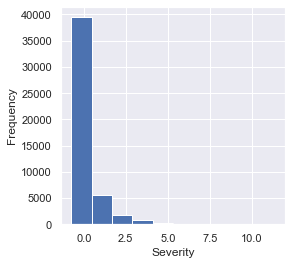

In [142]:
import matplotlib.pylab as plt

plt.figure()
plt.hist(scaled[:,0])
plt.xlabel("Severity")
plt.ylabel("Frequency")
# plt.savefig("graph.pdf")

<function matplotlib.pyplot.show(close=None, block=None)>

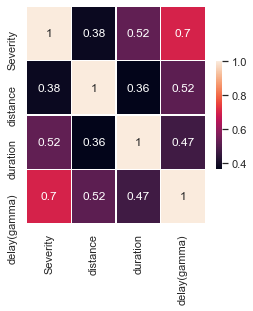

In [143]:
cor=pd.DataFrame(scaled,columns=["Severity","distance","duration","delay(gamma)"]).corr(method="kendall")
sns.set(rc={'figure.figsize':(4,4)})
sns.heatmap(cor,linewidths=.5, cbar_kws={"shrink": .5},annot=True,)
plt.show

In [144]:
scaled.shape

(48159, 4)

In [145]:
from tensorflow.keras.utils import to_categorical
x_train=scaled[:41000,:3]
y_train=scaled[:41000,3:]
x_test=scaled[41000:,:3]
y_test=scaled[41000:,3:]
print(x_train.shape,x_test.shape)

(41000, 3) (7159, 3)


# regression fitting

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
reg = LinearRegression().fit(x_train,y_train)
reg.score(x_test,y_test)
y=reg.predict(x_test)
print("mean_squared_error",mean_squared_error(y,y_test))
print("mean_absolute_error",mean_absolute_error(y,y_test))

mean_squared_error 0.14529736828223622
mean_absolute_error 0.24245978242253757


# Neural Network fitting

In [19]:
from tensorflow import keras
from tensorflow.keras.layers import Input 
from tensorflow.keras.models import Model
from tensorflow.keras import layers
inputs=Input(shape=(3))
d1=layers.Dense(3,activation='relu')(inputs)
d2=layers.Dense(3,activation='relu')(d1)
d3=layers.Dense(3,activation='relu')(d2)
d3=layers.Dense(3,activation='relu')(d3)
outputs=layers.Dense(1)(d3)

model=Model(inputs=[inputs],outputs=outputs)
opt = tf.keras.optimizers.Adam(learning_rate=0.0008)
model.compile(optimizer=opt, loss='mse',metrics=["mse","mae","mape"])
callback=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)

history=model.fit(x_train, y_train,callbacks=[callback],shuffle=False,epochs=200,batch_size=128,validation_data=(x_test,y_test), verbose=2)
print("test accuracy: ",model.evaluate(x_test,y_test)[1])

Epoch 1/200
321/321 - 3s - loss: 0.6392 - mse: 0.6392 - mae: 0.5760 - mape: 118.2949 - val_loss: 0.2056 - val_mse: 0.2056 - val_mae: 0.3642 - val_mape: 116.8117
Epoch 2/200
321/321 - 0s - loss: 0.2285 - mse: 0.2285 - mae: 0.3461 - mape: 130.2204 - val_loss: 0.1629 - val_mse: 0.1629 - val_mae: 0.2828 - val_mape: 126.2381
Epoch 3/200
321/321 - 0s - loss: 0.2165 - mse: 0.2165 - mae: 0.3184 - mape: 135.6971 - val_loss: 0.1547 - val_mse: 0.1547 - val_mae: 0.2703 - val_mape: 126.7719
Epoch 4/200
321/321 - 0s - loss: 0.2109 - mse: 0.2109 - mae: 0.3093 - mape: 134.5190 - val_loss: 0.1491 - val_mse: 0.1491 - val_mae: 0.2610 - val_mape: 124.5779
Epoch 5/200
321/321 - 0s - loss: 0.2059 - mse: 0.2059 - mae: 0.3011 - mape: 130.8289 - val_loss: 0.1447 - val_mse: 0.1447 - val_mae: 0.2538 - val_mape: 120.4638
Epoch 6/200
321/321 - 0s - loss: 0.2015 - mse: 0.2015 - mae: 0.2949 - mape: 126.7579 - val_loss: 0.1423 - val_mse: 0.1423 - val_mae: 0.2495 - val_mape: 116.8595
Epoch 7/200
321/321 - 0s - loss: 0

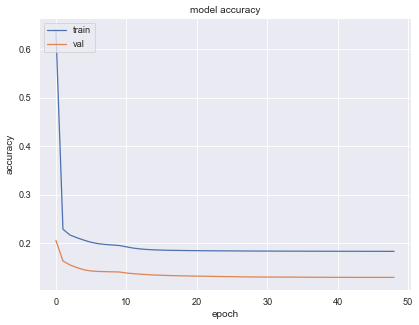

In [23]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=60)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

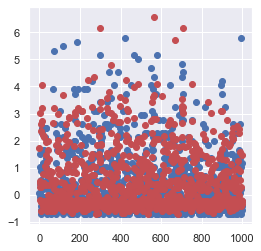

In [21]:
plt.plot(y_train[2000:3000,:],'bo')
plt.plot(model.predict(x_train[2000:3000,:], verbose=0),'ro')
plt.show()

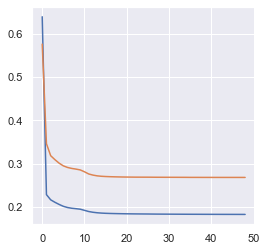

In [24]:
plt.plot(history.history['mse'])
plt.plot(history.history['mae'])
plt.show()

(array([4.864e+03, 1.309e+03, 5.110e+02, 2.250e+02, 1.310e+02, 7.100e+01,
        2.200e+01, 1.600e+01, 8.000e+00, 2.000e+00]),
 array([-0.8203277 , -0.06916718,  0.68199337,  1.4331539 ,  2.1843145 ,
         2.9354749 ,  3.6866355 ,  4.437796  ,  5.1889563 ,  5.940117  ,
         6.6912775 ], dtype=float32),
 <BarContainer object of 10 artists>)

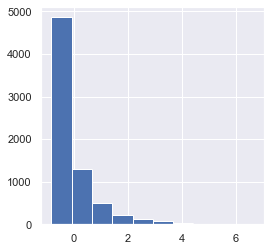

In [25]:
#predicted gamma of congestions (used in next blocks)
gamma_n=model.predict(x_train)
gamma_r=model.predict(x_train)
plt.hist(model.predict(x_test))

# import accident dataset

In [111]:
dfs1 = pd.read_excel(r'E:\bachelor project/2.xlsx')

In [112]:
dfs1 = dfs1[dfs1['Start_Time'].notna()]
dfs1["Acc_Time_Year"]=dfs1["Start_Time"].dt.year.astype(int)
dfs1["Acc_Time_Month"]=dfs1["Start_Time"].dt.month.astype(int)
dfs1["Acc_Time_Day"]=dfs1["Start_Time"].dt.day.astype(int)
dfs1["Acc_Time_Hour"]=dfs1["Start_Time"].dt.hour.astype(int)
dfs1["Acc_Time_Minute"]=dfs1["Start_Time"].dt.minute.astype(int)

dfs1["Acc_Time_Month"] = dfs1["Acc_Time_Month"].replace([1], '01')
dfs1["Acc_Time_Month"] = dfs1["Acc_Time_Month"].replace([2], '02')
dfs1["Acc_Time_Month"] = dfs1["Acc_Time_Month"].replace([3], '03')
dfs1["Acc_Time_Month"] = dfs1["Acc_Time_Month"].replace([4], '04')
dfs1["Acc_Time_Month"] = dfs1["Acc_Time_Month"].replace([5], '05')
dfs1["Acc_Time_Month"] = dfs1["Acc_Time_Month"].replace([6], '06')
dfs1["Acc_Time_Month"] = dfs1["Acc_Time_Month"].replace([7], '07')
dfs1["Acc_Time_Month"] = dfs1["Acc_Time_Month"].replace([8], '08')
dfs1["Acc_Time_Month"] = dfs1["Acc_Time_Month"].replace([9], '09')

#for days
dfs1["Acc_Time_Day"] = dfs1["Acc_Time_Day"].replace([1], '01')
dfs1["Acc_Time_Day"] = dfs1["Acc_Time_Day"].replace([2], '02')
dfs1["Acc_Time_Day"] = dfs1["Acc_Time_Day"].replace([3], '03')
dfs1["Acc_Time_Day"] = dfs1["Acc_Time_Day"].replace([4], '04')
dfs1["Acc_Time_Day"] = dfs1["Acc_Time_Day"].replace([5], '05')
dfs1["Acc_Time_Day"] = dfs1["Acc_Time_Day"].replace([6], '06')
dfs1["Acc_Time_Day"] = dfs1["Acc_Time_Day"].replace([7], '07')
dfs1["Acc_Time_Day"] = dfs1["Acc_Time_Day"].replace([8], '08')
dfs1["Acc_Time_Day"] = dfs1["Acc_Time_Day"].replace([9], '09')

#creating new time identifier
conditions = [
    (dfs1['Acc_Time_Hour'] > 0) & (dfs1['Acc_Time_Hour'] <= 2),
    (dfs1['Acc_Time_Hour'] > 2) & (dfs1['Acc_Time_Hour'] <= 4),
    (dfs1['Acc_Time_Hour'] > 4) & (dfs1['Acc_Time_Hour'] <= 6),
    (dfs1['Acc_Time_Hour'] > 6) & (dfs1['Acc_Time_Hour'] <= 8),
    (dfs1['Acc_Time_Hour'] > 8) & (dfs1['Acc_Time_Hour'] <= 10),
    (dfs1['Acc_Time_Hour'] > 10) & (dfs1['Acc_Time_Hour'] <= 12),
    (dfs1['Acc_Time_Hour'] > 12) & (dfs1['Acc_Time_Hour'] <= 14),
    (dfs1['Acc_Time_Hour'] > 14) & (dfs1['Acc_Time_Hour'] <= 16),
    (dfs1['Acc_Time_Hour'] > 16) & (dfs1['Acc_Time_Hour'] <= 18),
    (dfs1['Acc_Time_Hour'] > 18) & (dfs1['Acc_Time_Hour'] <= 20),
    (dfs1['Acc_Time_Hour'] > 20) & (dfs1['Acc_Time_Hour'] <= 22),
    (dfs1['Acc_Time_Hour'] > 22) & (dfs1['Acc_Time_Hour'] <= 24),
    ]
# create a list of the values we want to assign for each condition
values = ['01','02','03','04','05','06','07','08','09','10','11','12']
# create a new column and use np.select to assign values to it using our lists as arguments
dfs1["Acc_Time_patern"] = np.select(conditions, values)

# create time representation
dfs1["Acc_Time1"]=dfs1["Acc_Time_Year"].astype(str)+dfs1["Acc_Time_Month"].astype(str)+dfs1["Acc_Time_Day"].astype(str)+dfs1["Acc_Time_patern"].astype(str)
dfs1["Acc_Time1"]=dfs1["Acc_Time1"].astype(int)

In [119]:
#creating duration feature
dfs1["Acc_Time_Day"]=dfs1["Start_Time"].dt.day.astype(int)
dfs1["Acc_Time_Hour"]=dfs1["Start_Time"].dt.hour.astype(int)
dfs1["Acc_Time_Minute"]=dfs1["Start_Time"].dt.minute.astype(int)
dfs1["Acc_Time_Day2"]=dfs1["End_Time"].dt.day.astype(int)
dfs1["Acc_Time_Hour2"]=dfs1["End_Time"].dt.hour.astype(int)
dfs1["Acc_Time_Minute2"]=dfs1["End_Time"].dt.minute.astype(int)

dfs1["duration"]=(dfs1["Acc_Time_Day2"]-dfs1["Acc_Time_Day"])*60*24+(dfs1["Acc_Time_Hour2"]-dfs1["Acc_Time_Hour"])*60+(dfs1["Acc_Time_Minute2"]-dfs1["Acc_Time_Minute"])
dfs1=dfs1[dfs1["duration"]>0]

In [120]:
dfs1 = dfs1.sort_values(by=["Acc_Time1"]) 
dfs1 = dfs1[dfs1["Acc_Time1"]>=2016032210]
dfs1 = dfs1[dfs1["Acc_Time1"]<=2020063010]

In [121]:
#columns i & j represent latitude & longitude respectively
dfs1['geohash_code5'] = dfs1[['Start_Lat','Start_Lng']].apply(lambda x: gh.encode(x['Start_Lat'],x['Start_Lng'],precision=5),axis=1)

In [122]:
saved = dfs1.copy()

In [125]:
dfs1.head(3)

,ID,Source,TMC,Severity,Start_Time,End_Time,DU,Start_Lat,Start_Lng,End_Lat,...,Acc_Time_Day,Acc_Time_Hour,Acc_Time_Minute,Acc_Time_patern,Acc_Time1,Acc_Time_Day2,Acc_Time_Hour2,Acc_Time_Minute2,duration,geohash_code5
48253,A-97140,MapQuest,1900-07-19 00:00:00,3.0,2016-03-22 20:50:00,2016-03-22 22:25:00,95,33.998714,-118.176270,NaN,...,22,20,50,10,2016032210,22,22,25,95,9q5cq
48251,A-97146,MapQuest,1900-07-19 00:00:00,2.0,2016-03-22 22:17:00,2016-03-22 23:02:00,45,34.028297,-118.186256,NaN,...,22,22,17,11,2016032211,22,23,2,45,9q5cw
48252,A-97144,MapQuest,1900-07-19 00:00:00,3.0,2016-03-22 22:09:00,2016-03-22 23:10:00,61,34.031689,-118.418961,NaN,...,22,22,9,11,2016032211,22,23,10,61,9q5c9


In [126]:
acc = dfs1[['Acc_Time1', 'geohash_code5', 'duration', 'Distance(mi)', 'Severity']]

<ipython-input-127-13b01c14420f>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ac1=acc.groupby(['Acc_Time1',"geohash_code5"])["time",'geo'].agg(lambda x: pd.Series.mode(x)[0])


(array([6.3205e+04, 1.0097e+04, 1.0230e+03, 2.0900e+02, 1.2700e+02,
        4.0000e+01, 8.0000e+00, 8.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([ 1. ,  3.7,  6.4,  9.1, 11.8, 14.5, 17.2, 19.9, 22.6, 25.3, 28. ]),
 <BarContainer object of 10 artists>)

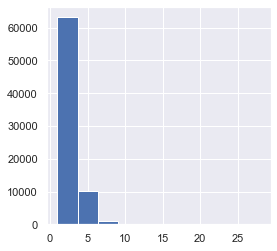

In [127]:
#groupby accident data
acc["time"]=acc["Acc_Time1"]
acc["geo"]=acc["geohash_code5"]
acc["acc_count"]=acc["duration"]
ac1=acc.groupby(['Acc_Time1',"geohash_code5"])["time",'geo'].agg(lambda x: pd.Series.mode(x)[0])
ac2=acc.groupby(['Acc_Time1',"geohash_code5"]).agg({"acc_count":"count","duration":"sum", "Distance(mi)":"sum","Severity":"sum"})
acc_grouped=pd.concat([ac1,ac2],axis=1)
acc_grouped

plt.hist(acc_grouped["Severity"])

(array([[2.2000e+01, 0.0000e+00, 0.0000e+00, 6.8908e+04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.9413e+04, 0.0000e+00, 1.2730e+03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.4793e+04,
         4.2760e+03, 4.5670e+03, 2.1560e+03, 1.3690e+03, 2.4550e+03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8293e+04, 3.6302e+04,
         4.4490e+03, 1.0700e+03, 4.2900e+02, 2.3900e+02, 8.8340e+03]]),
 array([-2.69230324, -2.12307292, -1.55384259, -0.98461227, -0.41538195,
         0.15384838,  0.7230787 ,  1.29230903,  1.86153935,  2.43076968,
         3.        ]),
 <a list of 3 BarContainer objects>)

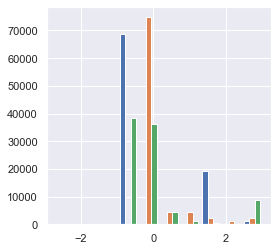

In [130]:
acc = dfs1.copy()
acc=acc[["Severity","Distance(mi)","duration"]]
accscaler = StandardScaler()
accscaler.fit(acc)
accscaled = accscaler.transform(acc)

#outliear treatment
a=accscaled[:,0]>3
accscaled[a,0]=3

a=accscaled[:,1]>3
accscaled[a,1]=3

a=accscaled[:,2]>3
accscaled[a,2]=3
plt.hist(accscaled[:,:])

In [147]:
#importing accidents with gamma labeled
gamma_n_acc = model.predict(accscaled)
dfs1["gamma_kmeans"]=gamma_n_acc #note that this columns and the below is filled with gamma's real values
# and will be replaced with gamma's class in the next code
dfs1["gamma_quantile"]=gamma_n_acc
# dfs1['geohash_code5'] = dfs1[['Start_Lat','Start_Lng']].apply(lambda x: gh.encode(x['Start_Lat'],x['Start_Lng'],precision=5),axis=1)
#dfs1.to_csv("C:/Users/vcc/Desktop/dars/term7/transportation/transportation project/final data/with gamma(new).csv")

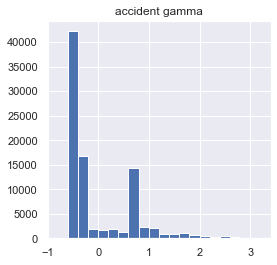

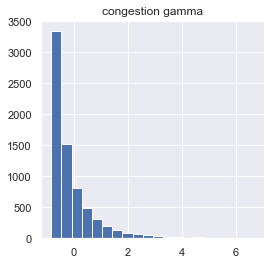

In [148]:
plt.hist(dfs1["gamma_kmeans"],bins=20)
plt.title("accident gamma")

plt.show()
plt.hist(model.predict(x_test),bins=20)
plt.title("congestion gamma")
plt.show()

In [149]:
#acc = pd.read_csv('C:/Users/vcc/Desktop/dars/term7/transportation/transportation project/final data/with gamma(new).csv')
acc=dfs1.copy()
acc=acc.sort_values(by=["Start_Time"])
acc=acc[acc["Acc_Time1"]>=2018000000]
acc=acc[acc["Acc_Time1"]<2020000000]

In [151]:
acc.shape

(64885, 62)

In [152]:
#groupby accident data
acc["time"]=acc["Acc_Time1"]
acc["geo"]=acc["geohash_code5"]
acc["acc_count"]=acc["duration"]
ac1=acc.groupby(['Acc_Time1',"geohash_code5"])["time",'geo'].agg(lambda x: pd.Series.mode(x)[0])
ac2=acc.groupby(['Acc_Time1',"geohash_code5"]).agg({"acc_count":"count","duration":"sum",
                                                       "Distance(mi)":"sum","Severity":"sum","Start_Lat":"mean",
                                                       "Start_Lng":"mean","gamma_kmeans":"sum","gamma_quantile":"sum"})
acc_grouped=pd.concat([ac1,ac2],axis=1)
acc_grouped

<ipython-input-152-d79349504f7c>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ac1=acc.groupby(['Acc_Time1',"geohash_code5"])["time",'geo'].agg(lambda x: pd.Series.mode(x)[0])


time    geo  acc_count  duration  \
Acc_Time1  geohash_code5                                           
2018010101 9q5dp          2018010101  9q5dp          1       365   
           9q5f0          2018010101  9q5f0          2       771   
           9q5f2          2018010101  9q5f2          1       360   
           9q5fr          2018010101  9q5fr          1       360   
2018010102 9q5by          2018010102  9q5by          2       720   
...                              ...    ...        ...       ...   
2019123111 9q5cx          2019123111  9q5cx          1        54   
           9q5dr          2019123111  9q5dr          1       115   
           9q5f3          2019123111  9q5f3          1        53   
           9q5f5          2019123111  9q5f5          1        73   
           9qh38          2019123111  9qh38          3       153   

                          Distance(mi)  Severity  Start_Lat   Start_Lng  \
Acc_Time1  geohash_code5                                                  
2018010101 9q5dp                 2.038       2.0  34.121100 -118.479720   
           9q5f0                 3.206       6.0  34.126604 -118.475266   
           9q5f2                 0.420       2.0  34.165340 -118.469730   
           9q5fr                 0.230       3.0  34.152030 -118.143760   
2018010102 9q5by                 0.684       6.0  33.915467 -118.188607   
...                                ...       ...        ...         ...   
2019123111 9q5cx                 0.000       2.0  34.016994 -118.141115   
           9q5dr                 0.000       2.0  34.170535 -118.501090   
           9q5f3                 0.000       2.0  34.156661 -118.413771   
           9q5f5                 0.000       2.0  34.101681 -118.316495   
           9qh38                 0.010       6.0  34.023881 -117.753415   

                          gamma_kmeans  gamma_quantile  
Acc_Time1  geohash_code5                                
2018010101 9q5dp              1.758836        1.758836  
           9q5f0              5.268949        5.268949  
           9q5f2              0.336435        0.336435  
           9q5fr              1.111829        1.111829  
2018010102 9q5by              2.154596        2.154596  
...                                ...             ...  
2019123111 9q5cx             -0.486194       -0.486194  
           9q5dr             -0.256197       -0.256197  
           9q5f3             -0.492480       -0.492480  
           9q5f5             -0.366769       -0.366769  
           9qh38             -1.315124       -1.315124  

[52948 rows x 10 columns]

In [52]:
dfs1['gamma_kmeans'] = dfs1['gamma_kmeans'].fillna(0)

In [156]:
def gamma_quantile_classification(gamma):
    gamma=np.sort(gamma)
    conditions = [
    (gamma <= np.percentile(gamma,[50])[0]),
    (gamma > np.percentile(gamma,[50])[0])
    ]
    values = [1,2]
    gamma_class1 = np.select(conditions, values)
    return gamma_class1

gamma         -0.430354
class gamma    0.000000
dtype: float64
gamma          0.962005
class gamma    1.000000
dtype: float64


(array([63134.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 26482.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

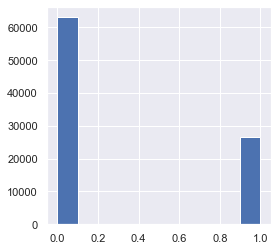

In [154]:
#kmeans classification
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(dfs1["gamma_kmeans"].values.reshape(-1,1))
gamma_class2=kmeans.labels_
#برای اینکه مطمئن شویم عددی که به کلاس هر گاما داده میشود متناسب با مقدار عددی گاما باشد
#مثلا میانگین مقادیر گاما با کلاس 0 بزرگتر از  میانگین مقادیر گاما با کلاس 1 نباشد
gamma_class2=gamma_class2.reshape(-1)
gamma_n=dfs1["gamma_kmeans"].values.reshape(-1,1).reshape(-1)
df=pd.DataFrame()
df["gamma"]=gamma_n
df["class gamma"]=gamma_class2
print(df[df["class gamma"]==0].mean())
print(df[df["class gamma"]==1].mean())
# print(df[df["class gamma"]==2].mean())
plt.hist(df["class gamma"])

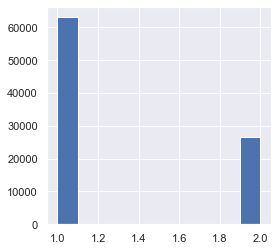

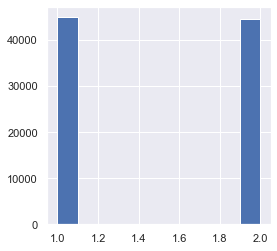

In [157]:
dfs1["gamma_value"]=dfs1["gamma_kmeans"]
dfs1["gamma_kmeans"]=df["class gamma"].values+1 #به علاوه یک میکنیم تا کلاس ها 1و2 باشند
dfs1["gamma_quantile"]=gamma_quantile_classification(dfs1["gamma_quantile"].values.reshape(-1,1))
plt.hist(dfs1["gamma_kmeans"])
plt.show()
plt.hist(dfs1["gamma_quantile"])
plt.show()

In [1]:
dfs1.drop(['Acc_Time_Year', 'Acc_Time_Month','Acc_Time_Day', 'Acc_Time_Hour', 'Acc_Time_Minute', 'Acc_Time_patern', 
           'Acc_Time_Hour2', 'Acc_Time_Minute2', 'Acc_Time_Day2'],axis=1,inplace=True)

In [168]:
dfs1

,ID,Source,TMC,Severity,Start_Time,End_Time,DU,Start_Lat,Start_Lng,End_Lat,...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Acc_Time1,duration,geohash_code5,gamma_kmeans,gamma_quantile,gamma_value
48253,A-97140,MapQuest,1900-07-19 00:00:00,3.0,2016-03-22 20:50:00,2016-03-22 22:25:00,95,33.998714,-118.176270,NaN,...,Night,Night,Night,Night,2016032210,95,9q5cq,2,2,1.074274
48251,A-97146,MapQuest,1900-07-19 00:00:00,2.0,2016-03-22 22:17:00,2016-03-22 23:02:00,45,34.028297,-118.186256,NaN,...,Night,Night,Night,Night,2016032211,45,9q5cw,1,1,-0.542764
48252,A-97144,MapQuest,1900-07-19 00:00:00,3.0,2016-03-22 22:09:00,2016-03-22 23:10:00,61,34.031689,-118.418961,NaN,...,Night,Night,Night,Night,2016032211,61,9q5c9,2,2,0.860566
48250,A-97173,MapQuest,1900-07-19 00:00:00,2.0,2016-03-23 07:08:00,2016-03-23 07:53:00,45,33.918877,-118.278282,NaN,...,Day,Day,Day,Day,2016032304,45,9q5bu,1,1,-0.542764
48249,A-97210,MapQuest,1900-07-19 00:00:00,3.0,2016-03-23 12:08:00,2016-03-23 12:38:00,30,34.055008,-118.214218,NaN,...,Day,Day,Day,Day,2016032306,30,9q5ct,2,2,0.749829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,A-561584,MapQuest,1900-07-19 00:00:00,2.0,2020-06-30 09:21:00,2020-06-30 10:35:00,74,33.993782,-118.182968,NaN,...,Day,Day,Day,Day,2020063005,74,9q5cq,1,2,-0.360483
3,A-561615,MapQuest,1900-07-19 00:00:00,3.0,2020-06-30 16:40:00,2020-06-30 17:10:00,30,33.959728,-118.280655,NaN,...,Day,Day,Day,Day,2020063008,30,9q5ch,2,2,0.734145
2,A-561628,MapQuest,1900-07-19 00:00:00,3.0,2020-06-30 19:09:00,2020-06-30 19:55:00,46,33.930126,-118.280563,NaN,...,Day,Day,Day,Day,2020063010,46,9q5ch,2,2,0.768608
1,A-561630,MapQuest,1900-07-19 00:00:00,3.0,2020-06-30 19:11:00,2020-06-30 20:11:00,60,34.032688,-118.219986,NaN,...,Day,Day,Day,Day,2020063010,60,9q5ct,2,2,0.856606


In [169]:
dfs1.to_csv(r'E:\bachelor project\accident_dataset with gamma.csv')